In [1]:
import os
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.mixed_precision import set_global_policy

2025-01-01 13:42:56.404148: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-01 13:42:56.470996: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-01 13:42:56.471058: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-01 13:42:56.472310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-01 13:42:56.482450: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Enable mixed precision
policy = 'mixed_float16'
set_global_policy(policy)
print(f"Mixed precision enabled with policy: {policy}")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]  # 4GB limit
            )
    except RuntimeError as e:
        print(f"Failed to set virtual device configuration: {e}")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Laptop GPU, compute capability 8.6
Mixed precision enabled with policy: mixed_float16


2024-12-31 22:27:19.235155: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-31 22:27:19.327355: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-31 22:27:19.327436: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-31 22:27:19.328442: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf


In [3]:
import sys
# Add the scripts folder to the system path
scripts_path = os.path.abspath(os.path.join('..', 'scripts/python'))
sys.path.append(scripts_path)


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
# Enable mixed precision training
from tensorflow.keras.mixed_precision import set_global_policy
from utils import (
    create_transformer_for_classical_style,
    train_transformer_for_classical_style,
    create_diffusion_model,
    train_diffusion_for_classical_style,
    generate_classical_poem
)

# Configure visualization settings
%matplotlib inline


In [5]:

# Define Paths
processed_data_path = '../data/processed/processed_taweel_data.csv'
diffusion_output_dir = '../models/diffusion'
transformer_output_dir = '../models/transformers'

os.makedirs(diffusion_output_dir, exist_ok=True)
os.makedirs(transformer_output_dir, exist_ok=True)

# Load and Inspect Data
print("Loading processed data...")
processed_df = pd.read_csv(processed_data_path, encoding='utf-8-sig')
print(f"Processed data loaded with {len(processed_df)} records.")

# Subset for Quick Testing (Optional)
subset = False
if subset:
    print("Using subset for testing...")
    train_df, valid_df = train_test_split(processed_df, test_size=0.2, random_state=42)
    train_subset = train_df.sample(n=100, random_state=42)  # Adjust as needed
    valid_subset = valid_df.sample(n=20, random_state=42)
else:
    train_df, valid_df = train_test_split(processed_df, test_size=0.2, random_state=42)
    train_subset, valid_subset = train_df, valid_df

print(f"Training records: {len(train_subset)}; Validation records: {len(valid_subset)}")


Loading processed data...
Processed data loaded with 103441 records.
Training records: 82752; Validation records: 20689


In [6]:
# ------------------------ #
# 1. Train the Transformer  #
# ------------------------ #

print("Training Transformer in auto-encoder style for classical poems...")
tokenizer_name = "t5-small"  # Use a Seq2Seq model
tok = AutoTokenizer.from_pretrained(tokenizer_name)

# Create the Transformer Model
transformer_model = create_transformer_for_classical_style(model_name=tokenizer_name, max_length=128)

# Prepare Training Data
sub_df = train_subset[['text']].copy()

# Train the Transformer
trained_transformer, hist = train_transformer_for_classical_style(
    df_classical=sub_df,
    tokenizer=tok,
    model=transformer_model,
    max_length=128,
    epochs=50,           # Adjust epochs as needed
    batch_size=2,       # Adjust batch size based on GPU memory
    output_dir=transformer_output_dir
)
print("Transformer training complete.")

Training Transformer in auto-encoder style for classical poems...


2024-12-31 23:24:30.197331: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-31 23:24:30.354798: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-31 23:24:30.354977: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-31 23:24:30.363908: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-31 23:24:30.364088: I external/local_xla/xla/stream_executor

Epoch 1/3


2024-12-31 23:25:17.328705: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9689005530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-31 23:25:17.328794: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-12-31 23:25:17.340611: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-31 23:25:17.377468: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1735705517.495028   61997 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33101/33101 [==============================] - 8557s 257ms/step - loss: 0.0100 - accuracy: 0.9975 - val_loss: 1.0910e-04 - val_accuracy: 1.0000
Epoch 2/3
33101/33101 [==============================] - 8193s 248ms/step - loss: 5.3855e-04 - accuracy: 0.9998 - val_loss: 6.7248e-05 - val_accuracy: 1.0000
Epoch 3/3
33101/33101 [==============================] - 6497s 196ms/step - loss: 2.4130e-04 - accuracy: 0.9999 - val_loss: 4.4242e-05 - val_accuracy: 1.0000
Transformer training complete.


In [7]:
# Save the final Transformer model
final_model_pat h = os.path.join(transformer_output_dir, "auto_encoder_transformer_model_final.h5")
trained_transformer.save_weights(final_model_path)
print(f"Final Transformer model saved to {final_model_path}")

# Save the tokenizer correctly
tokenizer_output_path = os.path.join(transformer_output_dir, "tokenizer")
tok.save_pretrained(tokenizer_output_path)
print(f"Tokenizer saved to {tokenizer_output_path}")

Final Transformer model saved to ../models/transformers/auto_encoder_transformer_model_final.h5
Tokenizer saved to ../models/transformers/tokenizer


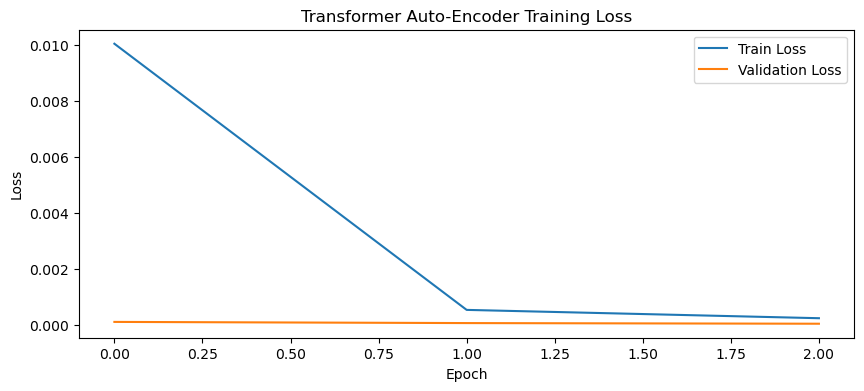

In [8]:
# Plot Transformer Training History
plt.figure(figsize=(10, 4))
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title("Transformer Auto-Encoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

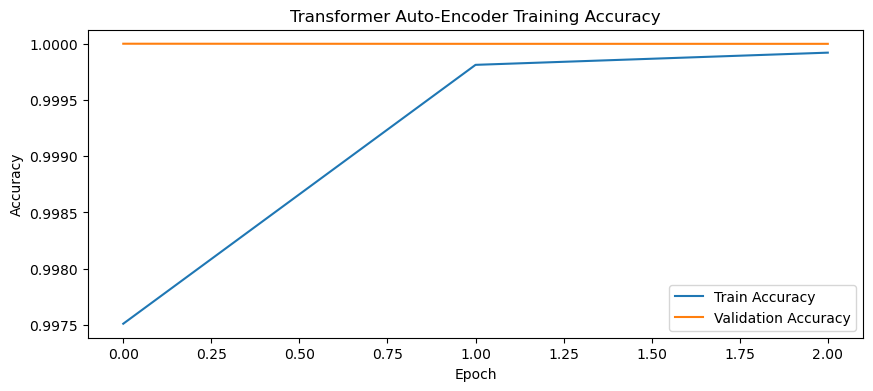

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title("Transformer Auto-Encoder Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [10]:
# ------------------------ #
# 2. Train the Diffusion    #
# ------------------------ #

import numpy as np

print("Creating diffusion model...")
# Define Diffusion Model Parameters
tokenizer_name = "t5-small"  # Use a Seq2Seq model
tok = AutoTokenizer.from_pretrained(tokenizer_name)

max_length = 128
max_bayt_len = 128
encoding_dim = 8
diffusion_model_params = {
    'num_transformer_blocks': 4,
    'num_heads': 8,
    'key_dim': 64,
    'ffn_units': 512
}

# Create Diffusion Model
input_shape = (max_bayt_len, encoding_dim)
diffusion_model = create_diffusion_model(input_shape, diffusion_model_params)

# Train Diffusion Model
batch_size = 8
epochs = 5
print("Training diffusion model...")
trained_diffusion_model, diffusion_hist = train_diffusion_for_classical_style(
    df_classical=train_subset,
    diffusion_model=diffusion_model,
    tokenizer=tok,
    max_length=max_length,
    max_bayt_len=max_bayt_len,
    encoding_dim=encoding_dim,
    epochs=epochs,
    batch_size=batch_size,
    output_dir=diffusion_output_dir
)
print("Diffusion model training complete.")


Creating diffusion model...
Model: "DiffusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 diffusion_input (InputLaye  [(None, 128, 8)]             0         []                            
 r)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 128, 8)               32        ['diffusion_input[0][0]']     
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 128, 8)               17928     ['batch_normalization[0][0]', 
 iHeadAttention)                                         

INFO:tensorflow:Assets written to: ../models/diffusion/diff_ckpt/assets


8276/8276 [==============================] - 524s 62ms/step - loss: 0.0087 - mae: 0.0249 - val_loss: 0.0039 - val_mae: 0.0464
Epoch 2/5
8276/8276 [==============================] - ETA: 0s - loss: 5.1665e-04 - mae: 0.0161   
Epoch 2: val_mae improved from 0.04643 to 0.01043, saving model to ../models/diffusion/diff_ckpt
INFO:tensorflow:Assets written to: ../models/diffusion/diff_ckpt/assets


INFO:tensorflow:Assets written to: ../models/diffusion/diff_ckpt/assets


8276/8276 [==============================] - 502s 61ms/step - loss: 5.1665e-04 - mae: 0.0161 - val_loss: 2.8857e-04 - val_mae: 0.0104
Epoch 3/5
8275/8276 [============================>.] - ETA: 0s - loss: 3.9132e-04 - mae: 0.0155   
Epoch 3: val_mae did not improve from 0.01043
8276/8276 [==============================] - 492s 59ms/step - loss: 3.9148e-04 - mae: 0.0155 - val_loss: 1.4951e-04 - val_mae: 0.0114
Epoch 4/5
8276/8276 [==============================] - ETA: 0s - loss: 3.7511e-04 - mae: 0.0152  
Epoch 4: val_mae improved from 0.01043 to 0.00531, saving model to ../models/diffusion/diff_ckpt
INFO:tensorflow:Assets written to: ../models/diffusion/diff_ckpt/assets


INFO:tensorflow:Assets written to: ../models/diffusion/diff_ckpt/assets


8276/8276 [==============================] - 524s 63ms/step - loss: 3.7511e-04 - mae: 0.0152 - val_loss: 1.2006e-04 - val_mae: 0.0053
Epoch 5/5
8276/8276 [==============================] - ETA: 0s - loss: 3.6340e-04 - mae: 0.0150   
Epoch 5: val_mae did not improve from 0.00531
8276/8276 [==============================] - 517s 63ms/step - loss: 3.6340e-04 - mae: 0.0150 - val_loss: 3.9056e-04 - val_mae: 0.0109
Diffusion model training complete.


In [11]:
# Save the final Diffusion model
final_diffusion_path = os.path.join(diffusion_output_dir, "diffusion_model_final.h5")
trained_diffusion_model.save_weights(final_diffusion_path)
print(f"Final diffusion model saved to {final_diffusion_path}")


Final diffusion model saved to ../models/diffusion/diffusion_model_final.h5


In [12]:
# Save the final model
final_model_path = os.path.join(transformer_output_dir, "auto-encoder_diffusion_model_final.h5")
trained_diffusion_model.save(final_model_path, include_optimizer=True)
print(f"Final Diffusion model saved to {final_model_path}")

# Save the tokenizer
tokenizer_output_path = os.path.join(transformer_output_dir, "tokenizer")
tok.save_pretrained(tokenizer_output_path)
print(f"Tokenizer saved to {tokenizer_output_path}")


/home/tarek/miniconda3/envs/baytdiffuser_env/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Final Diffusion model saved to ../models/transformers/auto-encoder_diffusion_model_final.h5
Tokenizer saved to ../models/transformers/tokenizer


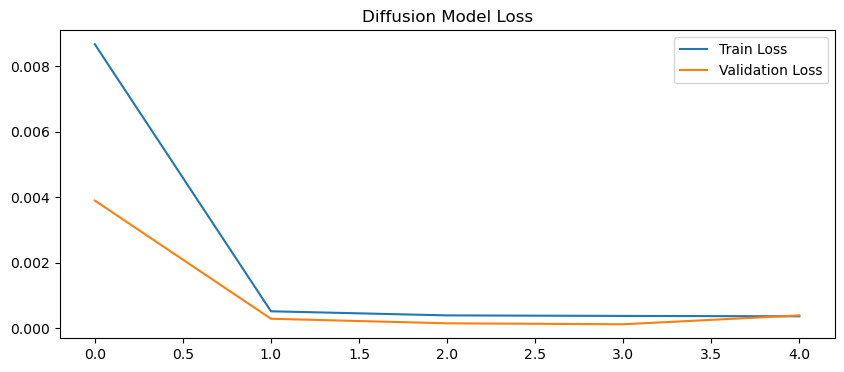

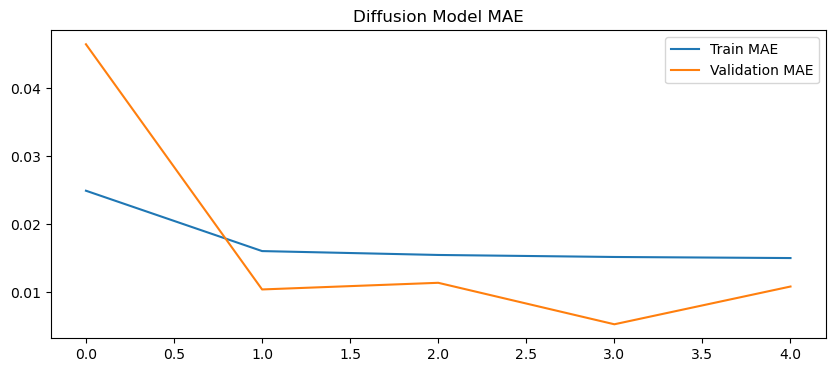

In [13]:
# Plot Diffusion Model Training History
plt.figure(figsize=(10, 4))
plt.plot(diffusion_hist.history['loss'], label='Train Loss')
plt.plot(diffusion_hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Diffusion Model Loss")
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(diffusion_hist.history['mae'], label='Train MAE')
plt.plot(diffusion_hist.history['val_mae'], label='Validation MAE')
plt.legend()
plt.title("Diffusion Model MAE")
plt.show()

In [14]:
# Save the final Diffusion model
final_diffusion_model_path = os.path.join(diffusion_output_dir, "diffusion_model_final.h5")
trained_diffusion_model.save_weights(final_diffusion_model_path)
print(f"Final Diffusion model saved to {final_diffusion_model_path}")

# Save the tokenizer used by both models
tokenizer_output_path = os.path.join(diffusion_output_dir, "tokenizer")
tok.save_pretrained(tokenizer_output_path)
print(f"Tokenizer saved to {tokenizer_output_path}")

Final Diffusion model saved to ../models/diffusion/diffusion_model_final.h5
Tokenizer saved to ../models/diffusion/tokenizer


In [6]:
# ------------------------ #
# 2. Load the Transformer and Diffusion Models
# ------------------------ #

def load_transformer_model(model_name, transformer_output_dir):
    """Load the Transformer model and its tokenizer."""
    print("Loading Transformer model...")
    transformer_model = create_transformer_for_classical_style(model_name=model_name, max_length=128)
    final_model_path = os.path.join(transformer_output_dir, "auto_encoder_transformer_model_final.h5")
    transformer_model.load_weights(final_model_path)
    print(f"Transformer model loaded from {final_model_path}")

    tokenizer_output_path = os.path.join(transformer_output_dir, "tokenizer")
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_output_path)
    print(f"Tokenizer loaded from {tokenizer_output_path}")
    
    return transformer_model, tokenizer

def load_diffusion_model(input_shape, diffusion_model_params, diffusion_output_dir):
    """Load the Diffusion model and its tokenizer."""
    print("Loading Diffusion model...")
    diffusion_model = create_diffusion_model(input_shape, diffusion_model_params)
    final_diffusion_model_path = os.path.join(diffusion_output_dir, "diffusion_model_final.h5")
    diffusion_model.load_weights(final_diffusion_model_path)
    print(f"Diffusion model loaded from {final_diffusion_model_path}")

    tokenizer_output_path = os.path.join(diffusion_output_dir, "tokenizer")
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_output_path)
    print(f"Tokenizer loaded from {tokenizer_output_path}")

    return diffusion_model, tokenizer

# Reload the models
tokenizer_name = "t5-small"  # Use a Seq2Seq model
tok = AutoTokenizer.from_pretrained(tokenizer_name)

max_length = 128
max_bayt_len = 128
encoding_dim = 8
diffusion_model_params = {
    'num_transformer_blocks': 4,
    'num_heads': 8,
    'key_dim': 64,
    'ffn_units': 512
}
transformer_model, tok = load_transformer_model(tokenizer_name, transformer_output_dir)
input_shape = (max_bayt_len, encoding_dim)
diffusion_model, tok = load_diffusion_model(input_shape, diffusion_model_params, diffusion_output_dir)

Loading Transformer model...


2025-01-01 13:43:24.066446: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-01 13:43:24.433202: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-01 13:43:24.433342: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-01 13:43:24.443531: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-01 13:43:24.443812: I external/local_xla/xla/stream_executor

Transformer model loaded from ../models/transformers/auto_encoder_transformer_model_final.h5
Tokenizer loaded from ../models/transformers/tokenizer
Loading Diffusion model...
Model: "DiffusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 diffusion_input (InputLaye  [(None, 128, 8)]             0         []                            
 r)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 128, 8)               32        ['diffusion_input[0][0]']     
 Normalization)                                                                                   
                                                                                                  
 multi_he

In [7]:
# ------------------------ #
# 3. Generate a Classical Poem
# ------------------------ #

modern_poem = (
    "إِذا الشَّعْبُ يومًا أرادَ الحياةَ فلا بُدَّ أنْ يَسْتَجيبَ "
    "القدرْ ولا بُدَّ للَّيْلِ أنْ يَنجلي ولا بُدَّ للقيدِ أن يَنْكَسِرْ "
    "ومَن لم يعانقْهُ شَوْقُ الحياةِ تَبَخَّرَ في جَوِّها واندَثَرْ "
    "فويلٌ لمَنْ لم تَشُقْهُ الحياةُ من صَفْعَةِ العَدَمِ المنتصرْ"
)

print("Generating classical poem...")

classical_poem = generate_classical_poem(
    modern_poem,
    transformer_model=transformer_model,
    tokenizer=tok,
    diffusion_model=diffusion_model,
    max_length=128
)

print("Generated Classical Poem:")
print(classical_poem)

Generating classical poem...


2025-01-01 13:43:46.189568: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fcf480041b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-01 13:43:46.189648: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2025-01-01 13:43:46.216321: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-01 13:43:46.285258: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1735757026.363240     641 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 1s 801ms/step
Generated Classical Poem:



In [ ]:
# ------------------------ #
# 3. Generate a Poem        #
# ------------------------ #

modern_poem = (
    "إِذا الشَّعْبُ يومًا أرادَ الحياةَ فلا بُدَّ أنْ يَسْتَجيبَ "
    "القدرْ ولا بُدَّ للَّيْلِ أنْ يَنجلي ولا بُدَّ للقيدِ أن يَنْكَسِرْ "
    "ومَن لم يعانقْهُ شَوْقُ الحياةِ تَبَخَّرَ في جَوِّها واندَثَرْ "
    "فويلٌ لمَنْ لم تَشُقْهُ الحياةُ من صَفْعَةِ العَدَمِ المنتصرْ"
)

print("Generating classical poem...")

classical_poem = generate_classical_poem(
    modern_poem,
    transformer_model=trained_transformer,
    tokenizer=tok,
    diffusion_model=trained_diffusion_model,
    max_length=128
)

print("Generated Classical Poem:")
print(classical_poem)


In [9]:
from utils import (
    inference_convert_modern_to_classical
)
def generate_classical_poem_without_diffusion(modern_poem, transformer_model, tokenizer, max_length=128):
    """
    Generates a classical poem from a modern poem using only a Transformer model.
    
    Args:
        modern_poem (str): The modern poem text.
        transformer_model (tf.keras.Model): The trained Transformer model.
        tokenizer (transformers.PreTrainedTokenizer): The tokenizer used by the Transformer.
        max_length (int): Maximum sequence length.
    
    Returns:
        str: The generated classical poem.
    """
    # Step 1: Transformer generates a rough classical poem
    classical_draft = inference_convert_modern_to_classical(
        modern_verse=modern_poem,
        tokenizer=tokenizer,
        model=transformer_model,
        max_length=max_length
    )
    
    # Directly return the classical draft generated by the Transformer
    return classical_draft


# ------------------------ #
# Generate a Classical Poem without Diffusion
# ------------------------ #

modern_poem = (
    "إِذا الشَّعْبُ يومًا أرادَ الحياةَ فلا بُدَّ أنْ يَسْتَجيبَ "
    "القدرْ ولا بُدَّ للَّيْلِ أنْ يَنجلي ولا بُدَّ للقيدِ أن يَنْكَسِرْ "
    "ومَن لم يعانقْهُ شَوْقُ الحياةِ تَبَخَّرَ في جَوِّها واندَثَرْ "
    "فويلٌ لمَنْ لم تَشُقْهُ الحياةُ من صَفْعَةِ العَدَمِ المنتصرْ"
)

print("Generating classical poem without diffusion...")

classical_poem = generate_classical_poem_without_diffusion(
    modern_poem=modern_poem,
    transformer_model=transformer_model,
    tokenizer=tok,
    max_length=128
)

print("Generated Classical Poem:")
print(classical_poem)


Generating classical poem without diffusion...
Generated Classical Poem:
           


In [12]:
import numpy as np
from utils import decode_refined_vectors

def test_diffusion_model(diffusion_model, fixed_input, max_length=128):
    """
    Tests the diffusion model by providing it with a fixed vectorized input.

    Args:
        diffusion_model (tf.keras.Model): The trained diffusion model.
        fixed_input (np.ndarray): A fixed binary vectorized input for testing.
        max_length (int): Maximum sequence length.

    Returns:
        str: The refined poem reconstructed from the diffusion model's output.
    """
    # Ensure the input is properly shaped for the diffusion model
    fixed_input = fixed_input.reshape(1, max_length, -1)  # Example: (1, 128, encoding_dim)

    # Predict using the diffusion model
    refined_vectors = diffusion_model.predict(fixed_input)

    # Post-process the output
    refined_vectors = np.rint(refined_vectors).astype(int).clip(min=0, max=1)  # Ensure binary

    # Decode the refined vectors into text tokens
    refined_tokens = decode_refined_vectors(refined_vectors[0])

    # Reconstruct the poem from tokens
    refined_poem = ''.join(refined_tokens).strip()

    return refined_poem

# ------------------------ #
# Test Diffusion Model with Fixed Input
# ------------------------ #

# Example fixed input for testing (random Arabic letter indices within Unicode range)
# Unicode range for Arabic letters: 0x0621 to 0x064A
arabic_range_start = 0x0621  # Arabic Letter Hamza
arabic_range_end = 0x064A    # Arabic Letter Yeh

# Generate random indices corresponding to Arabic letters
fixed_input = np.random.randint(arabic_range_start, arabic_range_end + 1, size=(128, 8))  # Example: (128, encoding_dim)

# Function to convert indices to Arabic characters
def indices_to_arabic_characters(indices):
    return ''.join([chr(index) for index in indices])

# Test the model
print("Testing diffusion model...")

refined_poem = test_diffusion_model(
    diffusion_model=diffusion_model,
    fixed_input=fixed_input,
    max_length=128
)

# Decode the fixed_input indices to Arabic characters for visualization
arabic_input = indices_to_arabic_characters(fixed_input.flatten())

print("Refined Poem from Diffusion Model:")
print(refined_poem)
print("Original Input (Arabic letters):")
print(arabic_input)


Testing diffusion model...
1/1 [==============================] - 0s 54ms/step
Refined Poem from Diffusion Model:
UNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNKUNK
Original Input (Arabic letters):
خلـعمخؽجتزؽضحرمقطحمغىآئذعبلجطضحققـزظتاداؾعحةضرإكأفضسـغؿلآؿعفزموثؼحبآشءئأؽػسذؽأخصؿحقغقآػفطلبؼأأءؽينحقضبؼئشظظىمإطرصػـوتشةإؤفذجنآككإمضشسصػؼثهيـؿخلأؿحؾتعجيظفحؼءىءزذؿزسضدقأهإزنإؤآجئغضظبؾظفصسةأواليظقةئؼركاثمؤءفؤدصصؿردكفلىيؤأشسوةباسـخلمـففؿنظخىنانزغئـذئؾزاءإةورىدـيضءبلغإءعؿنئؤزةهؿهأيؽطتعءهعمتهظئإمدثحػـوآؿضظبكأسووءطفؤؽاؿأشسغضحهلجتؽحغهصثمػئؿبإؿصـبءضؾغؾدىهسمتيئكجػنخئياجـسحصذصجكظواػةؤىؽجفهشبفزلؾثػؼءأحجؿنػطشتإئثطدؽإأتؾوزقهرةجؼدؿثطدةمعيصقنبذفثثوبؽقءغتزؿةذػاددؤبءؼفىلسبؽآويحسؾؽى